<a href="https://colab.research.google.com/github/Ermy99/covid-misinformation/blob/master/CS_4641_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing Misinformation
This is the group project for CS 4641 Machine Learning


In [ ]:
# Authenticate Google Drive access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My\ Drive/CS\ 4641\ Group\ Project/Data

/content/drive/.shortcut-targets-by-id/1vlC4jhknImpmn82qTXqa4s4-yhyn5KUY/CS 4641 Group Project/Data


In [ ]:
!pip install cmudict
!pip install tldextract

# Import and Clean Data

In [ ]:
import urllib.request
import pandas as pd

url = 'https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/corona_fake.csv'
urllib.request.urlretrieve(url,"corona_fake.csv")
df = pd.read_csv('corona_fake.csv')

df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'

df.loc[5]['label'] = 'FAKE'
df.loc[15]['label'] = 'TRUE'
df.loc[43]['label'] = 'FAKE'
df.loc[131]['label'] = 'TRUE'
df.loc[242]['label'] = 'FAKE'

#change all nan strings to empty string
df = df.fillna('')

print(df.tail())

                                                  title  ... label
1159   Could the Power of the Sun Slow the Coronavirus?  ...  TRUE
1160  Key evidence for coronavirus spread is flawed ...  ...  TRUE
1161  Summer Heat May Not Diminish Coronavirus Strength  ...  TRUE
1162               How Long Will a Vaccine Really Take?  ...  TRUE
1163  Why Funding the Covid-19 Response Could Be the...  ...  TRUE

[5 rows x 4 columns]


In [ ]:
import tldextract

sources = list()
true_false = list()
all_sources = list()

for i in range(len(df.index)):
  if str(df.loc[i]["label"]).lower() == "true":
    true_false.append("true")
  else:
    true_false.append("fake")

  source = str(df.loc[i]["source"]).lower()
  all_sources.append(source)
  domain = str(tldextract.extract(source).domain).lower()
  suffix = str(tldextract.extract(source).suffix).lower()
  if source == "facebook" or domain == "facebook" or source == "twitter" or domain == "twitter" or source == "youtube" or domain == "youtube":
    sources.append("facebook/twitter/youtube")
  elif source == "cdc" or domain == "cdc" or source == "who" or domain == "who":
    sources.append("medical")
  elif suffix == "edu" or source == "harvard" or domain == "harvard":
    sources.append("education")
  elif source == "europa" or domain == "europa" or suffix == "ca" or suffix == "ru":
    sources.append("government")
  elif source == "nytimes" or domain == "nytimes" or source == "cnn" or domain == "cnn" or source == "washingtonpost" or domain == "washingtonpost" or source == "usatoday" or domain == "usatoday" or source == "reuters" or domain == "reuters" or source == "archive" or domain == "archive" or source == "bbc" or domain == "bbc" or source == "rt" or domain == "rt":
    sources.append("news")
  else:
    sources.append("others")

df = df.drop(columns=['source', 'label'])
df['source'] = sources 
df['label'] = true_false 

print(str(len(true_false)) + " analyzed")

1164 analyzed


# Feature Engineering

## Tf-idf

In [ ]:
#tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
test = df.copy().fillna('')


vectorizer = TfidfVectorizer(stop_words='english', min_df=.2)
#sparse tfidf
tfidf_vectors = vectorizer.fit_transform(test['text'])
#column names
terms = vectorizer.get_feature_names()
tfidf_terms = []
for term in terms:
  tfidf_terms.append('tfidf_' + term)

tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_vectors, columns=tfidf_terms)

#tfidf_df.loc[tfidf_df['tfidf_virus']!=0, ['tfidf_virus']]
print(test.dtypes)
print(tfidf_df.dtypes)

#add to dataframe
tfidf_big = pd.concat((test,tfidf_df), axis=1)

title     object
text      object
source    object
label     object
dtype: object
tfidf_19           Sparse[float64, 0]
tfidf_according    Sparse[float64, 0]
tfidf_based        Sparse[float64, 0]
tfidf_called       Sparse[float64, 0]
tfidf_care         Sparse[float64, 0]
                          ...        
tfidf_work         Sparse[float64, 0]
tfidf_world        Sparse[float64, 0]
tfidf_wuhan        Sparse[float64, 0]
tfidf_year         Sparse[float64, 0]
tfidf_years        Sparse[float64, 0]
Length: 76, dtype: object


### References
Dataset : [towardsdatascience.com/automatically-detect-covid-19-misinformation-f7ceca1dc1c7](https://towardsdatascience.com/automatically-detect-covid-19-misinformation-f7ceca1dc1c7)

## Stylistic Analysis


In [ ]:
import urllib.request
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tag import pos_tag

def count_stopwords(text):
  #takes in string and returns the number of stopwords in itprint("counting stopwords..")
  STOPWORDS = set(stopwords.words('english'))
  word_vec = text.split()
  count=0
  for word in word_vec:
    if word in STOPWORDS:
      count +=1
  count /= (len(text)+1)
  return count

def count_pn(text): #potential problem: includes random words starting with a capital letter
  word_vec = text.split()
  tagged_sent = pos_tag(word_vec)
  propernouns = [word for word,pos in tagged_sent if ((pos == 'NNP') or (pos == 'NNPS'))]
  #print(propernouns)
  count_pn = len(propernouns)
  count_pn /= (len(text)+1)
  return count_pn

def count_adj(text):
  word_vec = text.split()
  tagged_sent = pos_tag(word_vec)
  adj = [word for word,pos in tagged_sent if ((pos == 'JJ') or (pos == 'JJR') or (pos == 'JJS'))]
  count_adj= len(adj)
  count_adj /= (len(text)+1)
  return count_adj

def count_negation(text): 
  word_vec = text.split()
  negation_words = ["no", "not", "none", "nobody", "nothing", "neither", "nowhere", "never", "dont", "don't", "shouldnt", "shouldn't"]
  count=0
  for word in word_vec:
    if word in negation_words:
      count +=1
  count /= (len(text)+1)
  return count

  #capital letter frequency
def capital_letter_freq(text):
    if not pd.isna(text):
        caps = sum(1 for c in text if c.isupper())
        length = max(1, len(text))
        return caps/length
    else:
        return 0

df['stopwords'] = df.apply(lambda row: count_stopwords(row.text), axis=1)
df['propernouns'] = df.apply(lambda row: count_pn(row.text), axis=1)
df['adjectives'] = df.apply(lambda row: count_adj(row.text), axis=1)
df['negation'] = df.apply(lambda row: count_negation(row.text), axis=1)
df['capital_letter_freq'] = df.apply(lambda row: capital_letter_freq(row.text), axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
import cmudict
import string
import re
import nltk

nltk.download('punkt')

def TTR(text):
  if len(text) == 0:
    return 0
  text = re.sub(r'[^\w]', ' ', text)
  text = text.lower()
  tokens = nltk.word_tokenize(text)
  types = nltk.Counter(tokens)

  return (len(types)/len(tokens))

def FKG_readability(text):
  # 0.39 * (wrd_ct / sent_ct) + 11.8 * (tot_syll / wrd_ct) - 15.59
  if len(text) == 0:
    return 0
  d = cmudict.dict()
  tot_syll = 0 
  words = text.split()
  table = str.maketrans('', '', string.punctuation)
  stripped_words = [w.translate(table) for w in words]
  for w in stripped_words:
    num_syll = max([len([y for y in x if y[-1].isdigit()]) for x in d[w.lower()]], default=None)
    num_syll = 1 if num_syll == None else num_syll
  # print("tot_syll " + str(tot_syll))

  wrd_ct = len(words)
  # print("wrd_ct " + str(wrd_ct))

  pattern  = re.compile(r'([^\.!?]*[\.!?])', re.M)
  sent_ct = len(pattern.findall(text))
  # print("sent_ct " + str(sent_ct))
  if sent_ct == 0:
    sent_ct = 1

  return (0.39 * (wrd_ct / sent_ct)) + (11.8 * (tot_syll / wrd_ct)) - 15.59
   

def GFG_readability(text):
 # 0.4 [(words/sentences) + 100 (words with > 3 syllables /words)]
  if len(text) == 0:
    return 0
  d = cmudict.dict()
  words = text.split()
  table = str.maketrans('', '', string.punctuation)
  stripped_words = [w.translate(table) for w in words]

  cplx_ct = 0 
  for w in stripped_words:
    num_syll = max([len([y for y in x if y[-1].isdigit()]) for x in d[w.lower()]], default=None)
    num_syll = 1 if num_syll == None else num_syll
    cplx_ct += 1 if num_syll > 3 else 0
  # print("cplx_ct " + str(cplx_ct))

  wrd_ct = len(words)
  # print("wrd_ct " + str(wrd_ct))

  pattern  = re.compile(r'([^\.!?]*[\.!?])', re.M)
  sent_ct = len(pattern.findall(text))
  if sent_ct == 0:
    sent_ct = 1
  # print("sent_ct " + str(sent_ct))

  return 0.4 * ((wrd_ct / sent_ct) + (100 * (cplx_ct / wrd_ct)))

def word_length(text):
  if len(text) == 0:
    return 0
  words = text.split()
  return sum(len(word) for word in words) / len(words)

def num_quotes(text):
  if len(text) == 0:
    return 0
  return ((len(text.split('"')) - 1)/2) / len(text)

  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print("Running TTR...")
df['TTR'] = df.apply(lambda row: TTR(row.text), axis=1)
#print("Running FKG...")
#df['FKG_readability'] = df.apply(lambda row: FKG_readability(row.text), axis=1)
#print("Running GFG...")
#df['GFG_readability'] = df.apply(lambda row: GFG_readability(row.text), axis=1)
print("Running word_length...")
df['word_length'] = df.apply(lambda row: word_length(row.text), axis=1)
print("Running num_quotes...")
df['num_quotes'] = df.apply(lambda row: word_length(row.text), axis=1)

## Sentiment Analysis

In [ ]:
from textblob import TextBlob

df['polarity'] = df.apply(lambda row: TextBlob(row.title + ' ' + row.text).sentiment.polarity, axis=1)
df['subjectivity'] = df.apply(lambda row: TextBlob(row.title + ' ' + row.text).sentiment.subjectivity, axis=1)

## Misspelling

In [ ]:
import nltk
import re
import sys

from nltk.corpus import stopwords
from nltk.corpus import words

nltk.download('stopwords')
nltk.download('words')

In [ ]:
# Combine sentences into one list, remove trailing spaces, remove symbols and make everything lower case 

sentences = list()

for i in range(len(df.index)):
  title = ""
  text = ""
  if df.loc[i]["title"]:
    title = str(df.loc[i]["title"])
  if df.loc[i]["text"]:
    text = str(df.loc[i]["text"])

  title = title.strip()
  title = re.sub('[^\w\d\s]', '', title)
  title = title.lower()

  text = text.strip()
  text = re.sub('[^\w\d\s]', '', text)
  text = text.lower()

  sentences.append((title.split(), text.split()))

print("number of sentences: " + str(len(sentences)))

In [ ]:
# Stop words we need to remove from the paragraph

stop_words = stopwords.words('english')
stop_words[:] = [re.sub('[^\w\d\s]', '', word) for word in stop_words]
stop_words[:] = [word.lower() for word in stop_words]

print("number of stop words: " + str(len(stop_words)))
print(stop_words)

In [ ]:
# Remove stop words

count_new = 0
count = 0

new_sentences = list()

for sentence in sentences:
  new_title_words = list()
  for j in range(len(sentence[0])):
    word = sentence[0][j]
    if word not in stop_words:
      new_title_words.append(word)
      count_new += 1
    count += 1

  new_text_words = list()
  for j in range(len(sentence[1])):
    word = sentence[1][j]
    if word not in stop_words:
      new_text_words.append(word)
      count_new += 1
    count += 1

  new_sentences.append([new_title_words, new_text_words])
  
  sys.stdout.write("\rwords analyzed: " + str(count))
  sys.stdout.flush()

sentences = new_sentences
print("\ntotal words remaining: " + str(count_new))

In [ ]:
# Count misspelling

count_new = 0
count = 0
title_misspellings_list = list()
text_misspellings_list = list()

english_words = set(words.words())

english_words.add("covid19")
english_words.add("coronavirus")
english_words.add("covid")

lower_set = set()
for word in english_words:
  lower_set.add(word.lower())
english_words = lower_set

new_sentences = list()

for sentence in sentences:
  new_title_words = list()
  count_not_misspelling = 0
  for j in range(len(sentence[0])):
    word = sentence[0][j]
    if word in english_words:
      new_title_words.append(word)
      count_not_misspelling += 1
      count_new += 1
    count += 1
  
  if len(sentence[0]) == 0:
    title_misspellings_list.append(0.0)
  else:
    title_misspellings_list.append((len(sentence[0]) - count_not_misspelling) / len(sentence[0]))

  new_text_words = list()
  count_not_misspelling = 0
  for j in range(len(sentence[1])):
    word = sentence[1][j]
    if word in english_words:
      new_text_words.append(word)
      count_not_misspelling += 1
      count_new += 1
    count += 1


  if len(sentence[1]) == 0:
    text_misspellings_list.append(0.0)
  else:
    text_misspellings_list.append((len(sentence[1]) - count_not_misspelling) / (len(sentence[1])))

  new_sentences.append([new_title_words, new_text_words])
  
  sys.stdout.write("\rwords analyzed: " + str(count))
  sys.stdout.flush()

sentences = new_sentences
print("\ntotal words remaining: " + str(count_new))

In [ ]:
df['title_misspelling_count'] = title_misspellings_list 
df['text_misspelling_count'] = text_misspellings_list 

In [ ]:
df

# Export

In [ ]:
df

In [ ]:
df.to_pickle("dataframe")

a = pd.concat((df,tfidf_df), axis=1)
a.to_pickle("ogdata_features_tfidf")
tfidf_df.to_pickle("just_tfidf")
b = df.drop('title',axis=1)
b = b.drop('text', axis=1)
b = b.drop('source', axis=1)
b = b.drop('label', axis=1)

b.to_pickle("just_features_no_tfidf")
b = pd.concat((b,tfidf_df), axis=1)
b.to_pickle("just_features_and_tfidf")


#df.to_pickle("with_tfidf")

# Clustering

## Normalized

In [ ]:
import pandas as pd
from sklearn import preprocessing

temp = df.drop(columns=['title', 'text', 'source', 'label'])
x = temp.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized = pd.DataFrame(x_scaled)

In [ ]:
print(normalized.columns)
normalized.to_pickle("normalized")

In [ ]:
source_loc = df.columns.get_loc("source")
label_loc = df.columns.get_loc("label")
np_df = df.to_numpy()
df_notext = df.drop(columns=['title', 'text', 'source', 'label'])
print("source " + str(source_loc))
print("label " + str(label_loc))

## PCA

## DBScan

<class 'numpy.ndarray'>


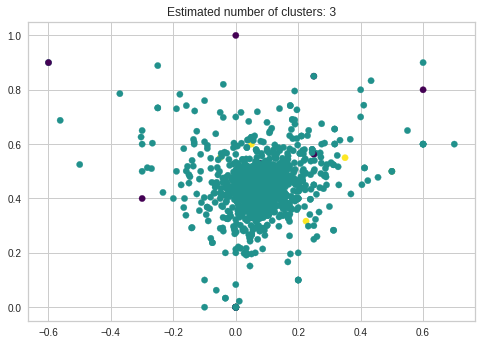

In [96]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from collections import Counter

X = df_notext.to_numpy()
print(type(X))
db = DBSCAN().fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

plt.scatter(X[:, df.columns.get_loc("polarity") - 4], X[:, df.columns.get_loc("subjectivity") - 4], c=labels, s=40, cmap='viridis');
plt.title('Estimated number of clusters: %d' % len(set(labels)))
plt.show()

## GMM

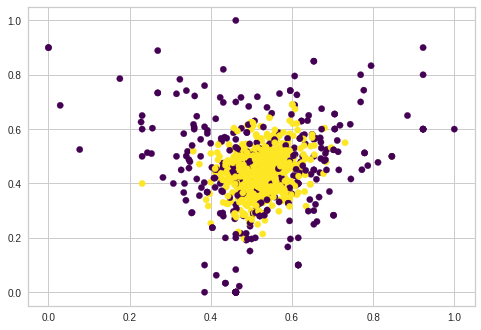

In [69]:
from sklearn.mixture import GaussianMixture

X = normalized.to_numpy()
gmm = GaussianMixture(n_components=2).fit(normalized)
labels = gmm.predict(normalized)
plt.scatter(X[:, df.columns.get_loc("polarity") - 4], X[:, df.columns.get_loc("subjectivity") - 4], c=labels, s=40, cmap='viridis');
plt.show()

df["gmm"] = labels

## K-Means

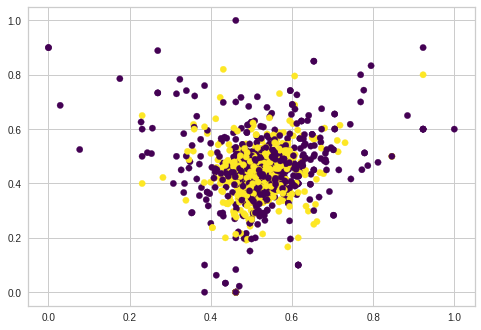

In [74]:
from sklearn.cluster import KMeans

X = normalized.to_numpy()
kmeans = KMeans(n_clusters=2).fit(X)
labels = kmeans.predict(X)
plt.scatter(X[:, df.columns.get_loc("polarity") - 4], X[:, df.columns.get_loc("subjectivity") - 4], c=labels, s=40, cmap="viridis");
plt.show()


0.8289738430583501
0.6558891454965358


Text(0.5, 1.0, 'F-Measures')

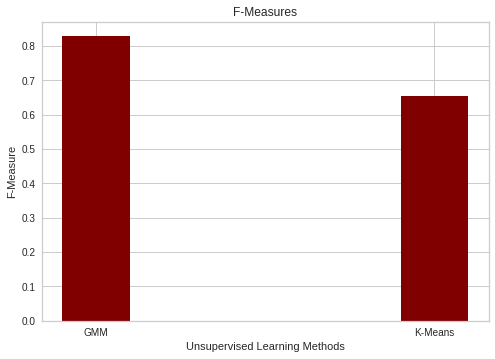

In [70]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


actual_labels = df['label'].tolist()

for idx in range(len(actual_labels)):
  actual_labels[idx] =  0 if actual_labels[idx] == 'FALSE' else 1

f_gmm = f1_score(actual_labels, df['gmm'].tolist(), average='weighted')
f_kmeans = f1_score(actual_labels, df['kmeans'].tolist(), average='weighted')
print(f_gmm)
print(f_kmeans)

algos = ['GMM', 'K-Means']
f_measures = [f_gmm, f_kmeans]
plt.bar(algos, f_measures, color ='maroon',  width = 0.2) 
plt.xlabel("Unsupervised Learning Methods") 
plt.ylabel("F-Measure") 
plt.title("F-Measures") 


# Visualizations

In [ ]:
from sklearn.datasets import make_blobs
from yellowbrick.cluster import SilhouetteVisualizer

X = df_notext.to_numpy()

kmeans = KMeans(n_clusters=2).fit(X)
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(X)

In [ ]:
from collections import Counter
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import dodge

dbscan_counter = Counter(list(df["dbscan"]))
kmeans_counter = Counter(list(df["dbscan"]))
gmm_counter = Counter(list(df["dbscan"]))

max_columns = max([len(dbscan_counter.keys()), len(kmeans_counter.keys()), len(gmm_counter.keys())])
print(max_columns)

output_notebook()

fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']
years = ['2015', '2016', '2017']

data = {'fruits' : fruits,
        '2015'   : [2, 1, 4, 3, 2, 4],
        '2016'   : [5, 3, 3, 2, 4, 6],
        '2017'   : [3, 2, 4, 4, 5, 3]}

source = ColumnDataSource(data=data)

p = figure(x_range=fruits, y_range=(0, 10), plot_height=250, title="Fruit Counts by Year",
           toolbar_location=None, tools="")

p.vbar(x=dodge('fruits', -0.25, range=p.x_range), top='2015', width=0.2, source=source,
       color="#c9d9d3", legend_label="2015")

p.vbar(x=dodge('fruits',  0.0,  range=p.x_range), top='2016', width=0.2, source=source,
       color="#718dbf", legend_label="2016")

p.vbar(x=dodge('fruits',  0.25, range=p.x_range), top='2017', width=0.2, source=source,
       color="#e84d60", legend_label="2017")

p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)

In [ ]:
from collections import Counter
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure

output_notebook()

factors = [
    ("K-Means", "Cluster 0"), ("K-Means", "Cluster 1"),
    ("GMM", "Cluster 0"), ("GMM", "Cluster 1"),
    ("DBScan", "Cluster 0"), ("DBScan", "Cluster 1"), ("DBScan", "Cluster 2"), ("DBScan", "Cluster 3")
]

dbscan_counter = Counter(list(df["dbscan"]))
kmeans_counter = Counter(list(df["kmeans"]))
gmm_counter = Counter(list(df["gmm"]))

for i in dbscan_counter.keys():
  dbscan_counter[i] = dbscan_counter[i] / 

regions = ['True', 'Fake']

source = ColumnDataSource(data=dict(
    x=factors,
    east=[ 5, 5, 5, 5, 4, 5, 6, 7, 8, 6, 9 ],
    west=[ 5, 9, 4, 5, 4, 7, 7, 7, 6, 6, 7 ],
))

p = figure(x_range=FactorRange(*factors), plot_height=250,
           toolbar_location=None, tools="")

p.vbar_stack(regions, x='x', width=0.9, alpha=0.5, color=["green", "red"], source=source, legend_label=regions)

p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
p.legend.location = "top_center"
p.legend.orientation = "horizontal"

show(p)